In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
random.seed(42)

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [3]:
block_size = 3

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [4]:
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])  
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,  Yte  = build_dataset(words[n2:])  

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad) # cool
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)

C  = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 for exercize, it's useless because of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters: p.requires_grad = True

4137


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim=True) # keep dim to get a matrix composed by the .sum(0) row vector
bndiff = hprebn - bnmeani # centering operation
bndiff2 = bndiff**2 # first step to compute variance
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # corrected var, note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5 # denominator
bnraw = bndiff * bnvar_inv # (x-μ)/sqrt(σ**2+ϵ)
hpreact = bngain * bnraw + bnbias # scale_γ* (x-μ)/sqrt(σ**2+ϵ) + shift_β

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb)), see Exercise 2
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability, since exp later with this we're ok
counts = norm_logits.exp() # e**zi
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv # col vect where each el is the sum of the unnormalized probs over the row
logprobs = probs.log() # logsoftmax 

loss = -logprobs[range(n), Yb].mean() # increase likelihood of correct log probabilities

# PyTorch backward pass
for p in parameters: p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

/home/marconobile/miniconda3/envs/karpathyAI/lib/python3.10/site-packages/torch/autograd/__init__.py:251: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400366987/work/c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(3.3411, grad_fn=<NegBackward0>)

In [9]:
# we start from the int version of the char, then we pass to their embeddings 
# and then we concat the embeddings to get the embed version of the 3-len seq of chars
Xb.shape, C[Xb].shape, C[Xb].view(C[Xb].shape[0], -1).shape

(torch.Size([32, 3]), torch.Size([32, 3, 10]), torch.Size([32, 30]))

In [10]:
# we take the activations pre-non-lin and we sum it collapsing the rows i.e. sum vertically to get a row vector 
# of the same dimensionality of the rows
hprebn.shape, hprebn.sum(0).shape, hprebn.sum(1).shape

(torch.Size([32, 64]), torch.Size([64]), torch.Size([32]))

In [11]:
# logits = log counts -> take max over the row 
logits.shape, logits.max(1, keepdim=True).values.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [12]:
logprobs[range(n), Yb].shape # increase likelihood of correct log probabilities

torch.Size([32])

# Exercise 1: manual backprop

In [13]:
# Let's start from:
# loss = -logprobs[range(n), Yb].mean()
print(logprobs.shape) 
# for each obs in batch, as output we have the pdist over the outclasses.
# for each obs [range(n),] we select the idx of the correct class [, Yb]
# which means that for each obs we select the logcount of the correct class, we sum them up and we take
# their (negative) mean

# IMPO: ONLY THE VALUES THAT ARE HERE CONSIDERED (I.E. THE LOGCOUNTS/LOGITS OF THE CORRECT CLASS GET GRADIENT!!!)
# because ONLY the logits/logcounts of the correct class (for each obj) partecipates/contributes in the computation 
# of the loss

torch.Size([32, 27])


## - The derivative for a tensor x must match the shape of the x tensor
## - When we take tensor.f(dim=1) we take the f over the rows, otherwise over cols
## - Every time you have a sum in the foward pass, you have a replication/broadcasting in the backward pass along the same dimension.
## - When we have a replication/broadcasting in the foward pass this implies a variable reuse which is handled in the backward pass via a sum over the same dimension

In [14]:
# We start from dloss/dloss = 1
# Given: 
# loss = -logprobs[range(n), Yb].mean(); 
# compute:
# dloss/dlogprob 

# idea: l = -(a+b+c)/3
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1./n 
cmp('logprobs', dlogprobs, logprobs)
assert logprobs.shape == dlogprobs.shape

# dloss/dlogprob = -1/n 

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


Summing the gradients due to individual samples you get a much smoother gradient. The larger the batch the smoother the resulting gradient used in updating the weight.

Dividing the sum by the batch size and taking the average gradient has the effect of:

1) The magnitude of the weight does not grow out of proportion. Adding L2 regularization to the weight update penalizes large weight values. This often leads to improved generalization performance. Taking the average, especially if the gradients happen to point in the same direction, keep the weights from getting too large.

2) The magnitude of the gradient is independent of the batch size. This allows comparison of weights from other experiments using different batch sizes.

3) Countering the effect of the batch size with the learning rate can be numerically equivalent but you end up with a learning rate that is implementation specific. It makes it difficult to communicate your results and experimental setup if people cannot relate to the scale of parameters you're using and they'll have trouble reproducing your experiment.

Averaging enables clearer comparability and keeping gradient magnitudes independent of batch size. Choosing a batch size is sometimes constrained by the computational resources you have and you want to mitigate the effect of this when evaluating your model.

In [15]:
# Given: 
# logprobs = probs.log()
# compute:
# dloss/dprobs = dloss/dlogprob * dlogprob/dprobs
 
# rule: d' log(x) = 1/x
dprobs =  dlogprobs * 1.0/probs # element-wise operations, chained grad * local derivative
# the idea: if obs[i] is being correctly classified then probs[i]=1 -> 1/1*chained grad
# the grad is passed thru. What does it mean for the grad to be passed thru?

# On the other hand if obs[i] is being misclassified then probs[i]<1 
# which implies that 1/probs[i] is large -> then grad is boosted, s.t. increase the magnitude of the 
# change that has to be apported to the weights s.t. classify correctly

# the application of the log acts as: 
# "identity func" on the grad for all the correct predictions and as a 
# grad booster for all the incorrect predictions

cmp('probs', dprobs, probs)
assert probs.shape == dprobs.shape

# dprobs =  -1/n * 1/probs

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [16]:
# Given: 
# probs = counts * counts_sum_inv
# compute:
# dloss/dcounts_sum_inv = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv

# pytorch does 2 things here:

    # 1) broadcasting to perform multiplication cuz:
    # counts.shape, counts_sum_inv.shape
    # (torch.Size([32, 27]), torch.Size([32, 1]))
    # so counts_sum_inv is replicated multiple time across the cols

    # 2) the multiplication itself is performed

    
# toy example:
# c = a * b 
# with a[3x3], b[3x1]
# a11, a12, a13    b1     a11*b1 a12*b1 a13*b1
# a21, a22, a23 *  b2  =  a21*b2 a22*b2 a23*b2
# a31, a32, a33    b3     a31*b3 a32*b3 a33*b3

# where b1=unnormalized prob of the first row (i.e. of the first example) 
# where b2=unnormalized prob of the second row (i.e. of the second example)
# where b3=unnormalized prob of the second row (i.e. of the second example)

# as we can see b1 is used 3 times in the first row, b2 3 times in the sec row, etc
# thus b_i is used X times and thus its gradient its the sum of its X local derivatives 
# eg for b1: a11, a12, a13 -> sum the cols

dstep1 = dprobs * counts
dstep2 = dstep1.sum(1, keepdim=True)
dcounts_sum_inv = dstep2
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
assert counts_sum_inv.shape == dcounts_sum_inv.shape

# dcounts_sum_inv = -1/n * 1/probs * counts

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
# Given: 
# probs = counts * counts_sum_inv 
# compute:
# dloss/dcounts = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts

print(dprobs.shape, counts_sum_inv.shape) # broadcasting makes shapes ok
dcounts = dprobs * counts_sum_inv
assert dcounts.shape == counts.shape

# we can't check yet cuz dcounts because counts is also used to compute counts_sum, and thus also the grad
# from this other branch of the computational graph has to be computed before checking

torch.Size([32, 27]) torch.Size([32, 1])


In [18]:
# Given: 
# counts_sum_inv = counts_sum**-1
# compute:
# dloss/dcounts_sum = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum

dcounts_sum = -1 * counts_sum**(-2) * dcounts_sum_inv
cmp('dcounts_sum', dcounts_sum, counts_sum)

assert counts_sum.shape == dcounts_sum.shape

# dcounts_sum = -1/n * 1/probs * counts * -1/counts_sum**2 = counts/(n*probs*counts_sum**2)

dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
# Given: 
# counts_sum = counts.sum(1, keepdims=True)
# compute:
# dloss/dcounts = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum * 
#     dcounts_sum/dcounts

# we already computed part of the counts derivative and it has shape: torch.Size([32, 27]),
# given that counts_sum.shape has shape torch.Size([32, 1]) we need to 

# a11, a12, a13 ---> b1 (= a11 + a12 + a13)
# a21, a22, a23 ---> b2 (= a21 + a22 + a23)
# a31, a32, a33 ---> b3 (= a31 + a32 + a33)

# db1/a11, db1/a12, db1/a13 ---> 1, 1, 1
# db2/a21, db2/a22, db2/a23 ---> 1, 1, 1
# db3/a31, db3/a32, db3/a33 ---> 1, 1, 1

# the sum can be seen as a router for the gradient: the gradient "coming from above" is routed "as-is" to each
# element that is partecipating in the sum.
# What happens here thus is the application of dcounts_sum col vector [32, 1] previously computed 
# replicated over all the cols ||||...|| till it is [32,27]

dcounts += torch.ones_like(counts_sum) * dcounts_sum
cmp('dcounts', dcounts, counts)
assert dcounts.shape == counts.shape

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


In [20]:
# Given: 
# counts = norm_logits.exp() 
# compute:
# dloss/dnorm_logits = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum * 
#     dcounts_sum/dcounts * dcounts/dnorm_logits

dnorm_logits = norm_logits.exp() * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)
assert counts.shape == dnorm_logits.shape

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


In [21]:
# Given: 
# norm_logits = logits - logit_maxes 
# compute:
# dloss/dlogits = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum * 
#     dcounts_sum/dcounts * dcounts/dnorm_logits * dnorm_logits/dlogits

# here we have to be careful with shapes:
# (torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

# c11, c12, c13     a11, a12, a13    b1 
# c21, c22, c23  =  a21, a22, a23  - b2  
# c31, c32, c33     a31, a32, a33    b3 

# thus c31 = a31 - b3 ----> +1, -1 

dlogits = dnorm_logits.clone() # for saefty
# logits are used in the computation of logit_maxes so no check

dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # for saefty
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes.clone().sum() # the grads of logit_maxes actually should be 0, here we are pretty close but not 0
# cuz of floating point arithmetic. Why 0? -> cuz we are subtracting logit_maxes to logits just for numerical
# stability and we can do this freely cuz with the softmax renormalization we are actually not changing the output 
# probabilities

zi = torch.tensor([.1, .1 , .5, .7])
zi_exp = zi.exp()
sum_zi_ezp = zi_exp.sum() 
pdist1 = zi_exp/sum_zi_ezp
print(pdist1, pdist1.sum())

zi = torch.tensor([.1, .1 , .5, .7])
zi -= zi.max()
zi_exp = zi.exp()
sum_zi_ezp = zi_exp.sum() 
pdist2 = zi_exp/sum_zi_ezp
print(pdist2, pdist2.sum())

assert torch.all(pdist1 == pdist2).item()

dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
tensor([0.1882, 0.1882, 0.2807, 0.3429]) tensor(1.0000)
tensor([0.1882, 0.1882, 0.2807, 0.3429]) tensor(1.0000)


In [22]:
# Given: 
# logit_maxes = logits.max(1, keepdim=True).values
# compute:
# dloss/dlogits = dloss/dlogprob * dlogprob/dprobs * dprobs/dcounts_sum_inv * dcounts_sum_inv/dcounts_sum * 
#     dcounts_sum/dcounts * dcounts/dnorm_logits * dnorm_logits/dlogits * dlogits/dlogit_maxes 
#     * dlogit_maxes/dlogits

# care about different shapes:
# logits.shape = torch.Size([32, 27]); logit_maxes.shape = torch.Size([32, 1])

# logits.max(1, keepdim=True) returns 2 things: 1) the (max) values 2) the indices if these maxes
# this is just a selection: local derivative = 1 * the gradient flowing from above

dlogits += F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('dlogits', dlogits, logits)

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


tensor([ 5,  2, 19, 15, 15, 25, 16,  3, 19,  8, 15,  3, 22,  5,  7,  5,  2,  1,
        22, 19, 15, 19, 22, 22, 23,  5, 22, 20, 24,  6, 24, 13])


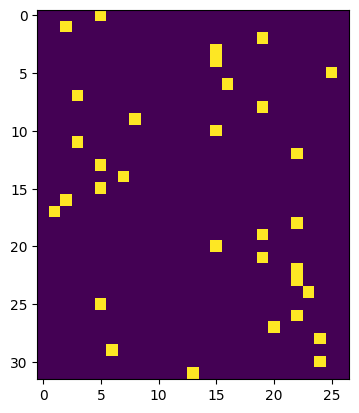

In [23]:
print(logits.max(dim=1).indices)
plt.imshow(F.one_hot(logits.max(dim=1).indices, num_classes=logits.shape[1])) # * dlogit_maxes
# which is equal to:

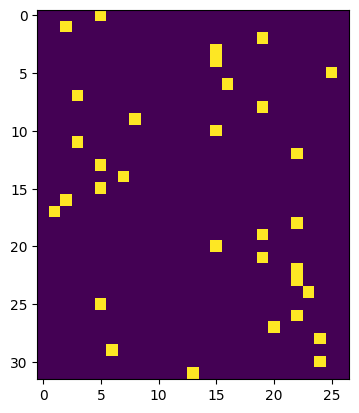

In [24]:
a = torch.zeros_like(logits)
a[range(n), logits.max(1).indices] = 1
plt.imshow(a)

In [25]:
# Given: 
# logits = h @ W2 + b2 # output layer
# compute:
# dloss/dh 

print(dlogits.shape, h.shape, W2.shape, b2.shape)

# let's try to find a toy example to generalize (pen and paper)
# but you can also follow the following criteria:

# h is [32, 64], so dh will be of the same shape
# we already know that dh will be a matrix multiplication between dlogits [32, 27] and
# W2 [64, 27], thus the only way to multiply a [32, 27] by a [64, 27] is to transpose the [64, 27] ()

dh = dlogits @ W2.T
cmp('dh', dh, h)

torch.Size([32, 27]) torch.Size([32, 64]) torch.Size([64, 27]) torch.Size([27])
dh              | exact: True  | approximate: True  | maxdiff: 0.0


In [26]:
# Given: 
# logits = h @ W2 + b2 # output layer
# compute:
# dloss/dW2 

# again: h.shape, dlogits.shape: (torch.Size([32, 64]), torch.Size([32, 27]))
# thus h.T @ dlogits

dW2 = h.T @ dlogits
cmp('dW2', dW2, W2)

dW2             | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
# Given: 
# logits = h @ W2 + b2 # output layer
# compute:
# dloss/db2

# again here we already know that we need to chain the gradient from dlogits torch.Size([32, 27]))
# and since b2 torch.Size([27]) then we know we need to eliminate the first dim of dlogits

db2 = dlogits.sum(0, keepdim=True)
cmp('db2', db2, b2)

db2             | exact: True  | approximate: True  | maxdiff: 0.0


In [28]:
# Given: 
# h = torch.tanh(hpreact)
# compute:
# dloss/dhpreact

# h.shape == hpreact.shape
dhpreact = (1.0 - h**2) * dh
cmp('dhpreact', dhpreact, hpreact)

dhpreact        | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [29]:
# Given: 
# hpreact = bngain * bnraw + bnbias 
# compute:
# dloss/dbngain

# given that bngain is being broadcasted across the rows, we need to sum all its grads (over the rows )

print(hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape)

dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # torch.Size([1, 64]) = torch.Size([32, 64]) * torch.Size([32, 64])
cmp('dbngain', dbngain, bngain)

torch.Size([32, 64]) torch.Size([1, 64]) torch.Size([32, 64]) torch.Size([1, 64])
dbngain         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [30]:
# Given: 
# hpreact = bngain * bnraw + bnbias 
# compute:
# dloss/dbnraw

dbnraw = dhpreact * bngain # cuz bngain here is relplicated/broadcasted just as in its forward pass 
cmp('dbnraw', dbnraw, bnraw)

dbnraw          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [31]:
# Given: 
# hpreact = bngain * bnraw + bnbias 
# compute:
# dloss/dbnbias

print(bnbias.shape, hpreact.shape)
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('dbnbias', dbnbias, bnbias)

torch.Size([1, 64]) torch.Size([32, 64])
dbnbias         | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [32]:
# Given: 
# bnraw = bndiff * bnvar_inv 
# compute:
# dloss/dbndiff
# dloss/dbnvar_inv

print(dbnraw.shape, bndiff.shape, bnvar_inv.shape)
dbndiff = bnvar_inv * dbnraw
# cmp('dbndiff', dbndiff, bndiff) Wrong cuz it is going to be reused, there is another branch

dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
dbnvar_inv      | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [33]:
# Given: 
# bnvar_inv = (bnvar + 1e-5)**-0.5
# compute:
# dloss/dbnvar

dbnvar = -.5 * (bnvar + 1e-5) **-1.5 * dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)

dbnvar          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [34]:
# Given: 
# bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
# compute:
# dloss/dbndiff2
# corrected var, note: Bessel's correction (dividing by n-1, not n)

print(bnvar.shape, bndiff2.shape)

# toy example:
# b1 = 1/(n-1) * (a11 + a12)
# b2 = 1/(n-1) * (a21 + a22)

dbndiff2 = 1/(n-1) * dbnvar * torch.ones_like(bndiff2)
cmp('dbndiff2', dbndiff2, bndiff2)

torch.Size([1, 64]) torch.Size([32, 64])
dbndiff2        | exact: False | approximate: True  | maxdiff: 2.9103830456733704e-11


In [35]:
# Given: 
# bndiff2 = bndiff**2 
# compute:
# dloss/dbndiff

dbndiff += 2 * bndiff * dbndiff2
cmp('dbndiff', dbndiff, bndiff)

dbndiff         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [36]:
# Given: 
# bndiff = hprebn - bnmeani
# compute:
# dloss/dhprebn
# dloss/dbnmeani

print(bndiff.shape, hprebn.shape, bnmeani.shape )# broadcast -> sum over the same dim, which here is 0

dhprebn = dbndiff.clone()
# cmp('dhprebn', dhprebn, hprebn) does not work bcuz used again
dbnmeani = (-dbndiff).sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)

torch.Size([32, 64]) torch.Size([32, 64]) torch.Size([1, 64])
dbnmeani        | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09


In [37]:
# Given: 
# bnmeani = 1/n * hprebn.sum(0, keepdim=True)
# compute:
# dloss/dhprebn

bnmeani.shape, hprebn.shape

dhprebn += 1/n * dbnmeani *  torch.ones_like(hprebn)
cmp('dhprebn', dhprebn, hprebn)

dhprebn         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [38]:
# Given: 
# hprebn = embcat @ W1 + b1
# compute:
# dloss/dembcat
# dloss/dW1
# dloss/db1

print(hprebn.shape, embcat.shape, W1.shape, b1.shape)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0, keepdim=True)

cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)

torch.Size([32, 64]) torch.Size([32, 30]) torch.Size([30, 64]) torch.Size([64])
dembcat         | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
dW1             | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
db1             | exact: False | approximate: True  | maxdiff: 3.958120942115784e-09


In [39]:
# Given: 
# embcat = emb.view(emb.shape[0], -1)
# compute:
# dloss/demb

print(dembcat.shape, emb.shape)
demb = dembcat.view(emb.shape) # view is just a superficial reshape
cmp('demb', demb, emb) 

torch.Size([32, 30]) torch.Size([32, 3, 10])
demb            | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09


In [40]:
# Given: 
# emb = C[Xb]
# compute:
# dloss/dC

# each row-idx of C represents a char and the whole row contains the prob of the next char
# for each occurrence of a char in Xb we need an addition
print(demb.shape, C[Xb].shape)      
# Xb contain indxs to be used to grab the correct entry in C

dC = torch.zeros_like(C) # derivative of same shape of the containing dstruct
for k in range(Xb.shape[0]): # for each obs in batch
    for j in range(Xb.shape[1]): # for each char used in obs
        ix = Xb[k,j] # get coords        
        dC[ix]+= demb[k,j] # given that emb is just C[Xb] with embeddings replacing chars we can index to pass grad
cmp('dC', dC, C) 

torch.Size([32, 3, 10]) torch.Size([32, 3, 10])
dC              | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


# Exercise 2: manual backprop without splitting softmax

In [41]:
# Backprop thru cross_entropy_loss but all in one go
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff: ', (loss_fast - loss).item())

3.3410890102386475 diff:  0.0


In [42]:
# forward pass cross entropy loss:
# we get logits, we apply softmax, we take idx of label and we take prob_i at idx of label,
# we apply -log(prob_i) -> average these for the whole batch = cross entropy loss

# backward pass cross entropy loss:
# dloss/dlogit_i = sum_for_all_i_in_batch/bs [-log(prob_i)] = 
#                = sum_for_all_i_in_batch/bs -log(e**logit_i/sum_for_all_js e**logit_j) = 
# where i is the indx of the correct label
# step1  set aside the 1/n and extract e**logit_i from the sum and drop log (logx = 1/x)
# step2 2 cases: 1 if i == j --> dloss/dlogit_i = 1 - prob_i
#                2 if i != j --> dloss/dlogit_i = prob_i
# so from our [bs x outclasses] we need to: do nothing if not at correct index, do -1 if at correct index 
# where prob_i is the prob vector obtained by applying the softmax function to the logits 
# recalling that the derivative of the sum is the sum of the derivatives we can easly backprop thru the mean
# and scale by 1/n

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1 
dlogits /= n
cmp('dlogits', dlogits, logits) 

dlogits         | exact: False | approximate: True  | maxdiff: 4.889443516731262e-09


# Intuition behind dlogits!

In [43]:
F.softmax(logits, 1)[0] # foward pass results for the first sample in batch
# the net is not yet trained so we don't have any real pattern here

tensor([0.0764, 0.0847, 0.0189, 0.0490, 0.0183, 0.0876, 0.0257, 0.0346, 0.0169,
        0.0309, 0.0375, 0.0388, 0.0391, 0.0272, 0.0340, 0.0134, 0.0089, 0.0191,
        0.0145, 0.0565, 0.0497, 0.0193, 0.0271, 0.0657, 0.0576, 0.0255, 0.0229],
       grad_fn=<SelectBackward0>)

In [44]:
dlogits[0] * n # backward pass results for the first sample in batch
# we can see that the correct probability has a large negative gradient (due to the -1) 
# while all the other values remained untouched from the forward pass!

tensor([ 0.0764,  0.0847,  0.0189,  0.0490,  0.0183,  0.0876,  0.0257,  0.0346,
        -0.9831,  0.0309,  0.0375,  0.0388,  0.0391,  0.0272,  0.0340,  0.0134,
         0.0089,  0.0191,  0.0145,  0.0565,  0.0497,  0.0193,  0.0271,  0.0657,
         0.0576,  0.0255,  0.0229], grad_fn=<MulBackward0>)

In [45]:
dlogits[0].sum() # sums to 0! Idea: for each row we are going to pull down the probabilities at wrong idxs, and 
# we are going to pull up the probability at the correct index. The ammount of push and pull is equal cuz the 
# sum of gradients is 0! The "how much we are pulling" is given by the magnitudes of out probabilities.  
# if we had perfect result then dlogits = torch.zeros
# the ammount of how much you prediction is incorrect defines how much push/pull it is going to be done in that 
# dimension.


# Observations:
# 1) if the nn is undecided between two classes, i.e. we have a negative gradient due to the -1, but we also have 
# a very wrong prediction for another class, then what happens is that the grad to diminish the wrongfully labeled
# class is equal to the gradient for the correct class

# 2) all of this is based on SGD on NegativeLogLikelihood (NLL): recalling that we want 
# max val in LogLikelihood (LL) -> min on NLL -> step in the direction of a negative grad = decrease loss

# 3) Goal: increase Ws that improve loss, decrease Ws that decrease loss
# update rule: p.data += - lr * p.grad
# if grad < 0 then update to p.data is positive, p increases
# if grad > 0 then update to p.data is negative, p decreases

tensor(6.9849e-10, grad_fn=<SumBackward0>)

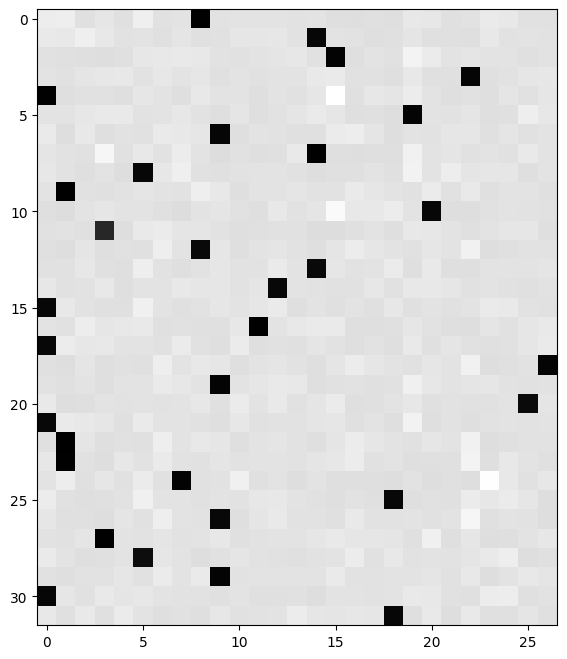

In [46]:
# Below we have a plot of a grid of size [bs x outclasses]. In the forward pass we can think of logits 
# as the raw unnormalized probabilities given by the nn.
# In the img above we have black squares where we removed a 1 cuz it was the logit of the correct answer, 

plt.figure(figsize=(8,8))
plt.imshow(dlogits.data, cmap='gray')

# Exercise 3: Derivation of batch norm in 1 step

In [47]:
# forward pass
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / \
    torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
    
print('max diff: ', (hpreact_fast - hpreact).abs().max())

max diff:  tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [48]:
# backward pass
# dloss/dhprebn given dhpreact (i.e. backprop thru BN layer)

dhprebn = bngain * bnvar_inv/n * (n*dhpreact -dhpreact.sum(0) - n/(n-1) * bnraw*(dhpreact*bnraw).sum(0))
cmp('dhprebn', dhprebn, hprebn) 

dhprebn         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


# Exercise 4: Train the MLP neural net with your own backward pass


In [82]:
def check_shapes(name, d, g): 
    print(name, d.shape, g.shape)
    assert d.shape == g.shape

In [87]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function


#         for t in [logits, h, W2, bnmean, b2 ,bnvar ,bnvar_inv ,bnraw ,hpreact, hprebn, embcat, emb]: 
#             t.retain_grad()

        # backward pass
        for p in parameters:
            p.grad = None
    #     loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! 
        dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None

        # -----------------
        # binary cross entropy backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1 
        dlogits /= n
        # cmp('dlogits', dlogits, logits) 

        # second layer backprop
        dh = dlogits @ W2.T    
        # cmp('dh', dh, h) 
        dW2 = h.T @ dlogits
        # cmp('dW2', dW2, W2) 
        db2 = dlogits.sum(0, keepdim=True)
        # cmp('db2', db2, b2) 

        # tanh backprop
        dhpreact = (1.0 - h**2) * dh
        # cmp('dhpreact', dhpreact, hpreact) 

        # batch norm backprop
        dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw*(dhpreact*bnraw).sum(0))
        # cmp('dhprebn', dhprebn, hprebn) 
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True) # torch.Size([1, 64]) = torch.Size([32, 64]) * torch.Size([32, 64])
        # cmp('dbngain', dbngain, bngain) 
        dbnbias = dhpreact.sum(0, keepdim=True)
        # cmp('dbnbias', dbnbias, bnbias) 

        # first layer backprop
        dembcat = dhprebn @ W1.T
        # cmp('dembcat', dembcat, embcat) 
        dW1 = embcat.T @ dhprebn
        # cmp('dW1', dW1, W1) 
        db1 = dhprebn.sum(0, keepdim=True)
        # cmp('db1', db1, b1) 
        
        # embedding backprop
        demb = dembcat.view(emb.shape) # view is just a superficial reshape
        # cmp('demb', demb, emb) 
        dC = torch.zeros_like(C) # derivative of same shape of the containing dstruct
        for k in range(Xb.shape[0]): # for each obs in batch
            for j in range(Xb.shape[1]): # for each char used in obs
                ix = Xb[k,j] # get coords        
                dC[ix]+= demb[k,j] # given that emb is just C[Xb] with embeddings replacing chars we can index to pass grad
        # cmp('dC', dC, C) 

        # -----------------    
        grads = [dC, dW1, db1.squeeze(), dW2, db2.squeeze(), dbngain, dbnbias]
        # -----------------
        
#         for p, grad in zip(parameters, grads):
#             check_shapes(str(tuple(p.shape)), p, grad)

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
#             p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

#         if i >= 100: # TODO: delete early breaking when you're ready to train the full net
#             break

12297
      0/ 200000: 3.7910
  10000/ 200000: 2.1903
  20000/ 200000: 2.3417
  30000/ 200000: 2.4356
  40000/ 200000: 2.0346
  50000/ 200000: 2.3475
  60000/ 200000: 2.4353
  70000/ 200000: 1.9937
  80000/ 200000: 2.3515
  90000/ 200000: 2.1714
 100000/ 200000: 1.9179
 110000/ 200000: 2.3189
 120000/ 200000: 2.0045
 130000/ 200000: 2.3963
 140000/ 200000: 2.2860
 150000/ 200000: 2.2051
 160000/ 200000: 1.9602
 170000/ 200000: 1.8293
 180000/ 200000: 2.0183
 190000/ 200000: 1.9335


In [89]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [90]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0720582008361816
val 2.1110851764678955


In [92]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)
        # sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
mad.
ryla.
rethruthadraegan.
chedielin.
shi.
jen.
eden.
sana.
arleigh.
malaia.
noshub.
roshiriel.
kindreelynn.
nophir.
ubented.
ryyah.
fael.
